In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
# Import data though csv
train_df = pd.read_csv('Train.csv', delimiter=',')
test_df = pd.read_csv('Test.csv', delimiter=',')

In [4]:
# Adding each train images to dataframe
X_train = []

for path in train_df['Path'].values:
    img = cv2.imread(path)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    X_train.append(img)

X_train = np.array(X_train)
y_train = train_df['ClassId'].values 

In [5]:
# Adding each test images to dataframe
X_test = []

for path in test_df['Path'].values:
    img = cv2.imread(path)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    X_test.append(img)

X_test = np.array(X_test)
y_test = test_df['ClassId'].values 

In [6]:
# Shuffling images to make it mora random
shuffle_indexes = np.arange(X_train.shape[0])
np.random.shuffle(shuffle_indexes)
X_train = X_train[shuffle_indexes]
y_train = y_train[shuffle_indexes]

In [7]:
y_train = keras.utils.to_categorical(y_train, 43)
y_test = keras.utils.to_categorical(y_test, 43)

print(y_train.shape)
print(y_test.shape)

(39209, 43)
(12630, 43)


In [8]:
# CNN model we used
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH , channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [9]:
lr = 0.001
epochs = 15

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
# Increasing the dataset with modified images
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Launching the training
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
1226/1226 [==============================] - 29s 23ms/step - loss: 1.7217 - accuracy: 0.5663 - val_loss: 0.2477 - val_accuracy: 0.9194
Epoch 2/15
1226/1226 [==============================] - 28s 23ms/step - loss: 0.1579 - accuracy: 0.9520 - val_loss: 0.1663 - val_accuracy: 0.9466
Epoch 3/15
1226/1226 [==============================] - 28s 23ms/step - loss: 0.0846 - accuracy: 0.9745 - val_loss: 0.1215 - val_accuracy: 0.9675
Epoch 4/15
1226/1226 [==============================] - 28s 23ms/step - loss: 0.0684 - accuracy: 0.9790 - val_loss: 0.0982 - val_accuracy: 0.9718
Epoch 5/15
1226/1226 [==============================] - 28s 22ms/step - loss: 0.0499 - accuracy: 0.9855 - val_loss: 0.0827 - val_accuracy: 0.9770
Epoch 6/15
1226/1226 [==============================] - 28s 23ms/step - loss: 0.0407 - accuracy: 0.9877 - val_loss: 0.1246 - val_accuracy: 0.9681
Epoch 7/15
1226/1226 [==============================] - 28s 23ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0753 -

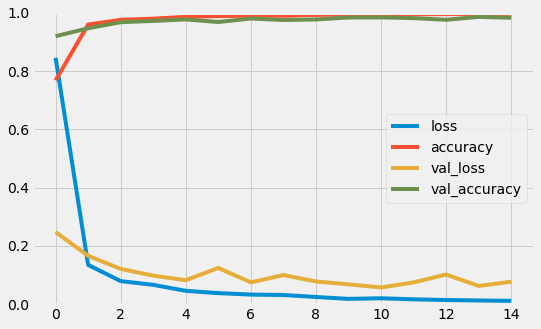

In [11]:
# Ploting differents interesting metrics
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [12]:
pred = model.predict_classes(X_test)

model.evaluate(X_test, y_test)

395/395 [==============================] - 2s 5ms/step - loss: 0.0773 - accuracy: 0.9827


[0.07731230556964874, 0.9826603531837463]

In [13]:
labels = test_df['ClassId'].values 

In [14]:
# Accuracy score
accuracy_score(labels, pred)

0.9826603325415677

<AxesSubplot:>

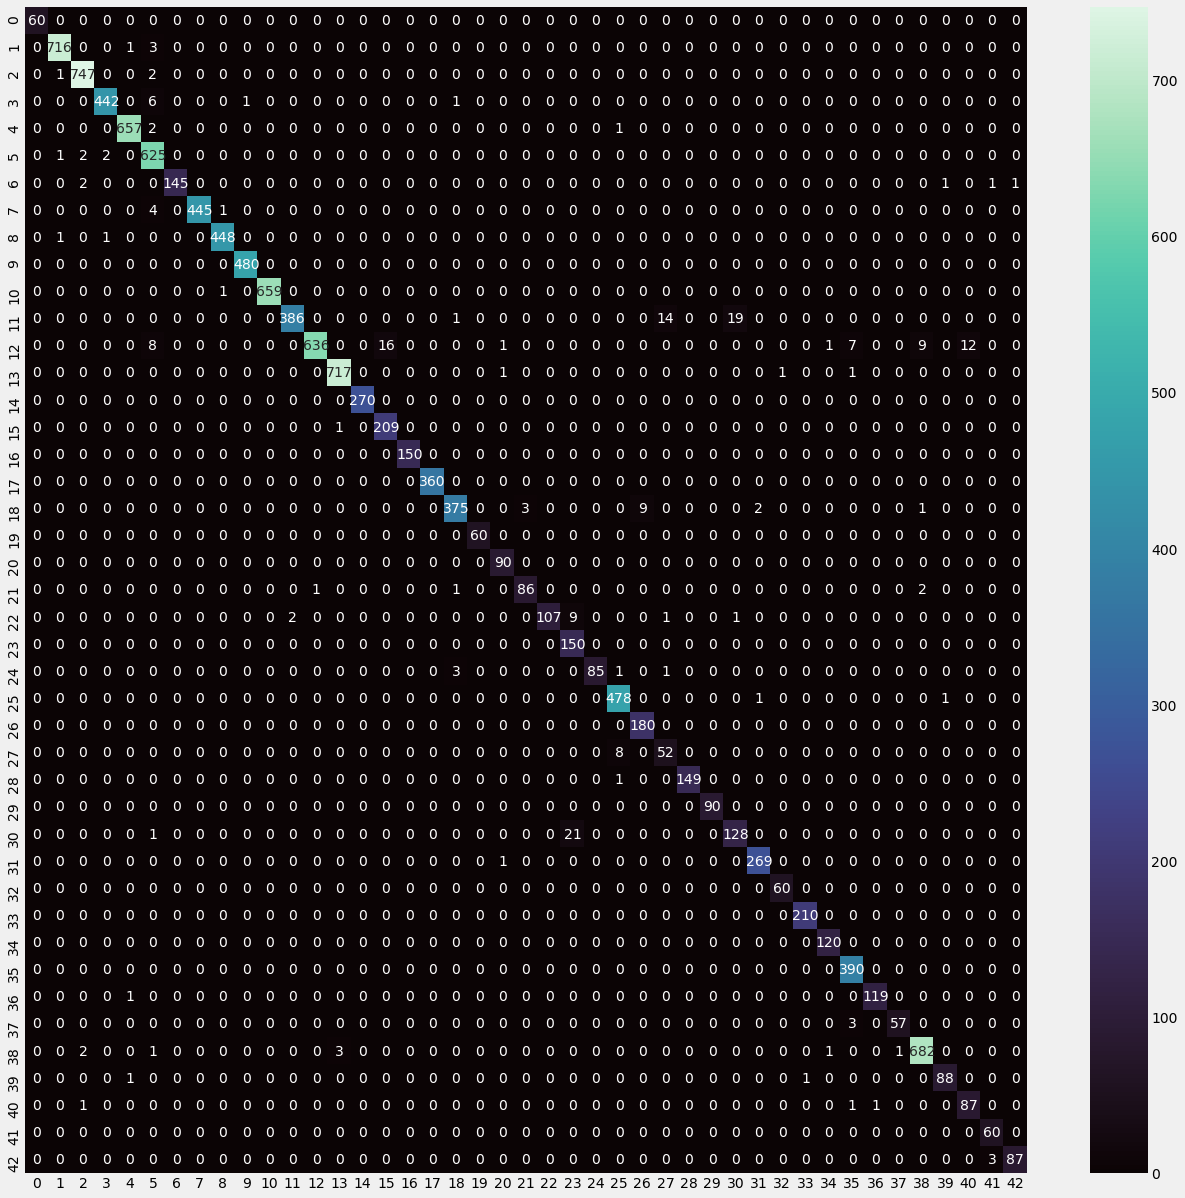

In [15]:
# Heatmap to see how images are classified
import seaborn as sns

conf = confusion_matrix(labels, pred)
plt.figure(figsize=(20, 20))
sns.heatmap(conf, cmap='mako', annot=True, fmt='d')

In [19]:
# Saving model to use it in the processing notebook
model.save('pano_model')

INFO:tensorflow:Assets written to: pano_model/assets
